## read folder

In [771]:
# read ecg

import os
import numpy as np
import pandas as pd
from typing import Tuple


FS_FALLBACK = 250.0                     # 若無時間欄，使用此取樣率

def load_ecg_csv(path: str) -> Tuple[pd.DataFrame, float, str]:
    """
    回傳: (df 只含 ['t_sec','wave'], fs_Hz, info)
    規則:
      - 若有 time/t/timestamp/sec/ms 等欄，嘗試判斷單位並換算成秒
      - 若沒有時間欄，用 FS_FALLBACK 與樣本索引建立時間
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f'File not found: {path}')
    df0 = pd.read_csv(path)
    if df0.empty:
        raise ValueError('Empty CSV.')

    cols = [c.lower().strip() for c in df0.columns]
    df0.columns = cols
    info = []

    # 嘗試找到時間欄
    t_col = next((c for c in ['t','time','timestamp','time_s','sec','seconds','ms','millisecond','milliseconds']
                  if c in df0.columns), None)

    if t_col is not None:
        t = pd.to_numeric(df0[t_col], errors='coerce').astype(float).values
        if len(t) < 2:
            raise ValueError('Time column too short to infer fs.')
        dt = np.diff(t)
        dt_med = float(np.nanmedian(dt))

        # 判斷秒或毫秒或索引
        if dt_med > 2:
            # 可能是樣本索引
            if (t % 1 == 0).mean() > 0.95:
                info.append('time looks like sample indices; using FS_FALLBACK')
                fs = float(FS_FALLBACK)
                t_sec = np.arange(len(t)) / fs
            else:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        elif dt_med > 0.02:
            info.append('time treated as seconds')
            t_sec = t
            fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        else:
            # 可能是毫秒
            if dt_med < 0.002:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
            else:
                info.append('time treated as milliseconds; converted to seconds')
                t_sec = t 
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))

        # 選 ECG 欄
        ecg_col = next((c for c in ['ecg','ecg_mv','lead1','lead_i','v1','value','signal']
                        if c in df0.columns and c != t_col), None)
        if ecg_col is None:
            # 取第一個非時間欄
            rest = [c for c in df0.columns if c != t_col]
            if not rest:
                raise ValueError('No ECG column found.')
            ecg_col = rest[0]
        ecg = pd.to_numeric(df0[ecg_col], errors='coerce').astype(float).values
    else:
        info.append('no time column; using FS_FALLBACK and sample index')
        fs = float(FS_FALLBACK)
        first_col = df0.columns[0]
        ecg = pd.to_numeric(df0[first_col], errors='coerce').astype(float).values
        t_sec = np.arange(len(ecg)) / fs

    df = pd.DataFrame({'t_sec': t_sec, 'wave': ecg})
    return df, fs, '; '.join(info) if info else 'inferred automatically'

def normalize_ts(df: pd.DataFrame,
                 y_candidates=('ecg','mmv','mmwave','heartbeat','value','signal'),
                 dt: float|None=None,
                 amp_method: str='absmax',  # 'absmax' or 'minmax'
                 eps: float=1e-12) -> pd.DataFrame:
    # 找 y 欄
    cols_lower = {c.lower(): c for c in df.columns}
    ycol = next((cols_lower[c] for c in cols_lower if c in y_candidates), None)
    if ycol is None:
        raise KeyError(f"找不到訊號欄。可用候選：{y_candidates}；現有欄位：{list(df.columns)}")

    out = df.copy()

    # 確保 t_sec
    if 't_sec' not in out.columns:
        if dt is None:
            raise KeyError("缺少 't_sec' 且未提供 dt。請給 dt，例如 0.1")
        out.insert(0, 't_sec', np.arange(len(out))*dt)

    # 只保留 t_sec + y 並統一命名
    out = out[['t_sec', ycol]].rename(columns={ycol: 'wave'}).copy()

    # 幅度歸一到 [-1, 1]
    x = out['wave'].astype(float).to_numpy()
    if amp_method == 'absmax':
        # 保零點，適合雙極性（ECG）
        s = np.nanmax(np.abs(x))
        s = s if s > eps else 1.0
        x_norm = x / s
    elif amp_method == 'minmax':
        # 線性映射到 [-1, 1]
        x_min, x_max = np.nanmin(x), np.nanmax(x)
        if x_max - x_min < eps:
            x_norm = np.zeros_like(x)
        else:
            x_norm = 2.0 * (x - x_min) / (x_max - x_min) - 1.0
    else:
        raise ValueError("amp_method must be 'absmax' or 'minmax'.")

    out['wave'] = np.clip(x_norm, -1.0, 1.0)
    return out

def pltot_fixed(df, title='Signal', label='sig'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.plot(df['t_sec'], df['wave'], label=label)
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title(title)
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

import numpy as np
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
# 你已有的 load_ecg_csv, normalize_ts 可沿用

def _butter_bandpass(x, fs, low=5, high=15, order=2):
    nyq = fs/2.0
    b, a = butter(order, [low/nyq, high/nyq], btype="bandpass")
    return filtfilt(b, a, x)

def _moving_avg(x, fs, win_sec=0.10):
    w = max(3, int(round(win_sec*fs)))
    k = np.ones(w)/w
    return np.convolve(x, k, mode="same")

def _calc_bpm_core(sig, fs):
    """與 SCP 腳本一致：對 |sig| 找峰，門檻 mean+0.5*std，最短間距 0.4s"""
    sig_abs = np.abs(sig)
    thr = np.mean(sig_abs) + 0.5*np.std(sig_abs)
    peaks, _ = find_peaks(sig_abs, height=thr, distance=int(0.4*fs))
    if len(peaks) < 2: 
        return None
    rr = np.diff(peaks)/fs
    mean_rr = float(np.mean(rr))
    return 60.0/mean_rr if mean_rr > 0 else None

def ecg_hr_csv_like_scp(path, print_each=True):
    """讀 CSV -> 正規化 -> 三法 HR：原始、5-15Hz 濾波、0.10s 移動平均；回傳平均與各法"""
    df, fs, info = load_ecg_csv(path)
    df = normalize_ts(df, y_candidates=('ecg','heartbeat','value','signal','wave'), amp_method='absmax')
    x = df['wave'].to_numpy(float)

    bpm_raw    = _calc_bpm_core(x, fs)
    bpm_butter = _calc_bpm_core(_butter_bandpass(x, fs, 5, 15, 2), fs)
    bpm_smooth = _calc_bpm_core(_moving_avg(x, fs, 0.10), fs)

    vals = [b for b in (bpm_raw, bpm_butter, bpm_smooth) if b is not None]
    bpm_mean = float(np.mean(vals)) if vals else None

    if print_each:
        print(f"HR(raw)={bpm_raw:.1f} bpm"     if bpm_raw    is not None else "HR(raw)=NA")
        print(f"HR(butter 5-15Hz)={bpm_butter:.1f} bpm" if bpm_butter is not None else "HR(butter)=NA")
        print(f"HR(smooth 0.10s)={bpm_smooth:.1f} bpm"  if bpm_smooth is not None else "HR(smooth)=NA")
        print(f"HR(mean of available)={bpm_mean:.1f} bpm" if bpm_mean is not None else "HR(mean)=NA")

    return {
        "fs_Hz": float(fs),
        "hr_mean_bpm": bpm_mean,
        "hr_raw_bpm": bpm_raw,
        "hr_butter_5_15_bpm": bpm_butter,
        "hr_smooth_0p10s_bpm": bpm_smooth,
        "info": info
    }

# 用法：
# out = ecg_hr_csv_like_scp("/mnt/data/1_1lead.csv")
# print(out)

In [772]:
# -----------------------------
# MMV CSV loader (keeps the same I/O contract)
# -----------------------------
import shutil

def _load_mmv_csv(csv_path: str) -> pd.DataFrame:
    """
    Expect columns: t_sec, heartbeat.
    Will coerce names if close variants are present.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"[error] mmv.csv not found: {csv_path}")
    df0 = pd.read_csv(csv_path)
    cols = {c.lower().strip(): c for c in df0.columns}

    # map possible variants
    tcol = None
    for k in ["t_sec", "t", "time", "time_s", "sec", "seconds"]:
        if k in cols: tcol = cols[k]; break
    ycol = None
    for k in ["heartbeat", "wave", "mmv", "value", "signal"]:
        if k in cols: ycol = cols[k]; break
    if tcol is None or ycol is None:
        raise ValueError(f"[error] require time and heartbeat columns. got: {list(df0.columns)}")

    df = pd.DataFrame({
        "t_sec": pd.to_numeric(df0[tcol], errors="coerce").astype(float),
        "heartbeat": pd.to_numeric(df0[ycol], errors="coerce").astype(float),
    }).dropna(subset=["t_sec", "heartbeat"]).reset_index(drop=True)
    return df

def process_vitals_folder(folder_path, outdir="outputs", fs_hint=10.0, show=False):
    """
    New behavior: read {folder_path}/mmv.csv.
    Output contract unchanged. Also write outdir/heart_rate_series.csv for compatibility.
    """
    mmv_path = os.path.join(folder_path, "mmv.csv")
    df = _load_mmv_csv(mmv_path)
    if df.empty:
        print("[error] mmv.csv is empty after parsing.")
        return None

    # infer fs from t_sec when possible; otherwise fall back
    t = df["t_sec"].to_numpy(float)
    fs = float(1.0 / np.nanmedian(np.diff(t))) if len(t) > 1 and np.isfinite(np.nanmedian(np.diff(t))) else float(fs_hint)

    os.makedirs(outdir, exist_ok=True)
    out_csv = os.path.join(outdir, "heart_rate_series.csv")

    # ensure exact columns as before
    df_out = df[["t_sec", "heartbeat"]].copy()
    df_out.to_csv(out_csv, index=False)

    if show:
        # quick preview plot
        plt.figure(figsize=(12, 3.5))
        plt.plot(df_out["t_sec"], df_out["heartbeat"], lw=0.9)
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.title("MMV heartbeat")
        plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    summary = {
        "samples": int(len(df_out)),
        "duration_s": float(df_out["t_sec"].iat[-1] - df_out["t_sec"].iat[0]) if len(df_out) > 1 else 0.0,
        "fs_Hz": float(fs),
        "est_hr_bpm": None,
        "csv": out_csv,
        "dataframe": df_out,
    }

    # also keep original file as the source of truth next to summary
    try:
        # if out_csv is not the same file, keep a copy already saved; else ignore
        if os.path.abspath(out_csv) != os.path.abspath(mmv_path):
            # optional: also drop a copy named mmv_original.csv
            shutil.copyfile(mmv_path, os.path.join(outdir, "mmv_original.csv"))
    except Exception:
        pass

    return summary

# unchanged
def transform_to_dataframe(summary):
    y = summary['dataframe']['heartbeat'].values
    dt = 0.1  # if you prefer using inferred fs: dt = 1.0/float(summary['fs_Hz'])
    t = np.arange(len(y)) * dt
    df = pd.DataFrame({'t_sec': t, 'mmv': y})
    return df

e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_1
HR(raw)=79.2 bpm
HR(butter 5-15Hz)=80.1 bpm
HR(smooth 0.10s)=78.6 bpm
HR(mean of available)=79.3 bpm


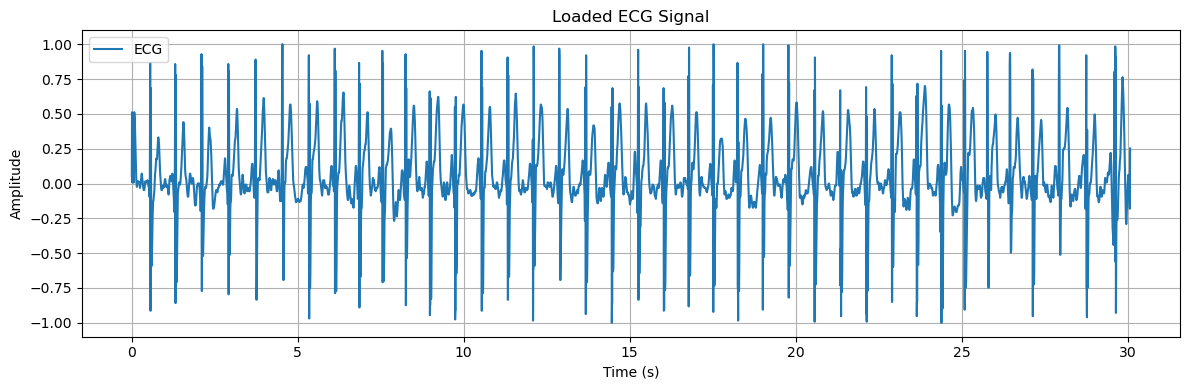

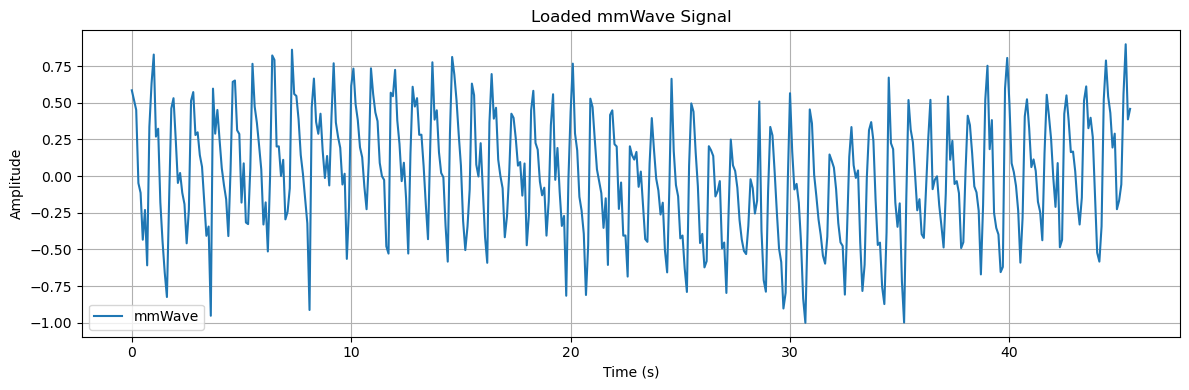

In [773]:
if __name__ == "__main__": #test
    import os
    cwd = os.getcwd()
    path=os.path.join(cwd, 'data','sample_1')
    print(path)
    df_ecg, fs_Hz, info = load_ecg_csv(path+'/1_1lead.csv') #read ecg
    res = ecg_hr_csv_like_scp(path+'/1_1lead.csv')
    res['hr_smooth_0p10s_bpm']


    summary = process_vitals_folder(path, outdir="outputs") # read mmv floder
    df_mmv= transform_to_dataframe(summary) 

    df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('wave',), dt=None)
    pltot_fixed(df_ecg_fixed, title='Loaded ECG Signal', label='ECG')
    df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)
    pltot_fixed(df_mmv_fixed, title='Loaded mmWave Signal', label='mmWave')



In [774]:
# input folder get sub folder (sample_n) 
import os
from pathlib import Path
import re
import random

def get_sample_subdirs(root):
    root = Path(root)
    patt = re.compile(r"sample_\d+$")   # sample_1, sample_2, ...
    subs = [p for p in root.iterdir() if p.is_dir() and patt.fullmatch(p.name)]
    # sort by the numeric suffix
    subs.sort(key=lambda p: int(p.name.split("_")[1]))
    return subs

path= os.getcwd()+'/data'
# example
all_sample_wave=[] # [folder_name,ecg,mmw,rebuilding]
for p in get_sample_subdirs(path):
    print(p)
    # read ecg
    df_ecg, fs_Hz, info = load_ecg_csv(str(p)+'/1_1lead.csv') #read ecg
    res = ecg_hr_csv_like_scp(str(p)+'/1_1lead.csv')
    
    # read mmv
    summary = process_vitals_folder(p, outdir="outputs") # read mmv floder
    df_mmv= transform_to_dataframe(summary) 
    df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('wave',), dt=None)
    df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)
    all_sample_wave.append({'path':p,'ecg':df_ecg_fixed,'mmv':df_mmv_fixed,'summary':summary,'ecg_hr_res':res['hr_smooth_0p10s_bpm']} )
    print(f'size of ecg: {len(df_ecg_fixed)}, size of mmv: {len(df_mmv_fixed)}, hr from ecg: {res["hr_smooth_0p10s_bpm"]}')


e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_0
HR(raw)=84.7 bpm
HR(butter 5-15Hz)=84.5 bpm
HR(smooth 0.10s)=81.1 bpm
HR(mean of available)=83.4 bpm
size of ecg: 4512, size of mmv: 290, hr from ecg: 81.13184604461216
e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_1
HR(raw)=79.2 bpm
HR(butter 5-15Hz)=80.1 bpm
HR(smooth 0.10s)=78.6 bpm
HR(mean of available)=79.3 bpm
size of ecg: 4512, size of mmv: 456, hr from ecg: 78.625101003012
e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_2
HR(raw)=80.4 bpm
HR(butter 5-15Hz)=80.9 bpm
HR(smooth 0.10s)=80.4 bpm
HR(mean of available)=80.6 bpm
size of ecg: 4512, size of mmv: 396, hr from ecg: 80.37200960163266
e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_3
HR(raw)=89.7 bpm
HR(butter 5-15Hz)=90.1 bpm
HR(smooth 0.10s)=86.9 bpm
HR(mean of available)=88.9 bpm
size of ecg: 4512, size of mmv: 370, hr from ecg: 86.88384619834756
e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_4
HR(raw)=89.

e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_181
size of ecg: 4512, size of mmv: 420


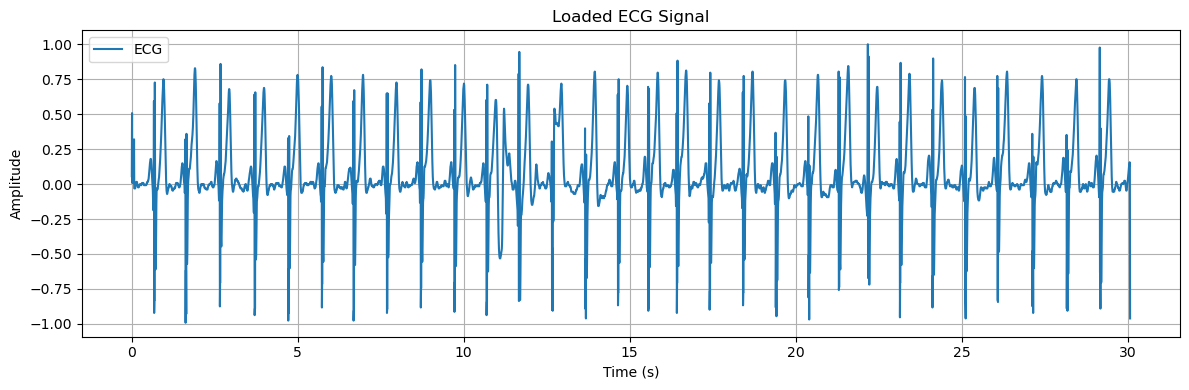

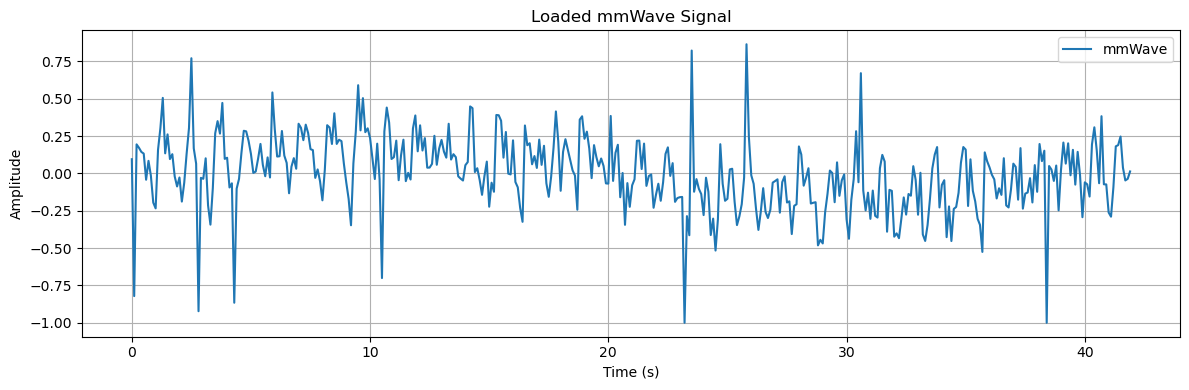

In [775]:
for i in all_sample_wave:
    pass
print(i['path'])
print(f'size of ecg: {len(i["ecg"])}, size of mmv: {len(i["mmv"])}')
pltot_fixed(i['ecg'], title='Loaded ECG Signal', label='ECG')
pltot_fixed(i['mmv'], title='Loaded mmWave Signal', label='mmWave')


## preprocessing

In [776]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter, stft, istft, iirnotch, butter, filtfilt
from scipy.signal import hilbert

# ===== 公用工具（中文註解）=====
def bandpass(sig, fs, lo=0.8, hi=3.0, order=4): # 帶通濾波：心跳頻段 (0.8–3.0 Hz)
    # 帶通濾波：心跳頻段 (0.8–3.0 Hz)
    ny = 0.5*fs
    b, a = butter(order, [lo/ny, hi/ny], btype='band')
    return filtfilt(b, a, sig)

def notch_at(sig, fs, f0, Q=30): # 陷波：抑制呼吸基頻與其諧波
    # 陷波：抑制呼吸基頻與其諧波
    if f0 <= 0 or f0 >= fs/2:
        return sig
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, sig)

def peak_hr_bpm(x, fs, lo=0.8, hi=3.0):  # 頻域主峰估 HR（粗略）
    # 頻域主峰估 HR（粗略）
    n = len(x)
    f = np.fft.rfftfreq(n, 1/fs)
    X = np.abs(np.fft.rfft(x))
    band = (f>=lo) & (f<=hi)
    if not np.any(band):
        return np.nan
    idx = np.argmax(X[band])
    f_pk = f[band][idx]
    return f_pk*60.0

def agc_rms(x, fs, target_rms=0.6, attack_ms=30, release_ms=200, eps=1e-12):
    # 自動增益控制：讓振幅看起來一致（可選）
    a = np.exp(-1.0/(fs*attack_ms/1000.0))
    r = np.exp(-1.0/(fs*release_ms/1000.0))
    y = np.zeros_like(x, dtype=float)
    env = 0.0
    for i, xi in enumerate(x):
        e2 = xi*xi
        if e2 > env:
            env = a*env + (1-a)*e2
        else:
            env = r*env + (1-r)*e2
        g = target_rms/(np.sqrt(env)+eps)
        y[i] = xi*g
    return y

def envelope_norm(x, q=0.8, eps=1e-12):
    # 以 Hilbert 包絡做分位數正規化（可選，避免尖峰主導）
    env = np.abs(hilbert(x))
    scale = np.quantile(env, q)+eps
    return x/scale

def plot_triplet(t, x_raw, x_filt, title, overlay_alpha=0.9, ylims=None):
    # 三聯圖：Raw / Filtered / Overlay（全英文抬頭）
    fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharex=True)
    axes[0].plot(t, x_raw, linewidth=1)
    axes[0].set_title("Raw")
    axes[1].plot(t, x_filt, linewidth=1)
    axes[1].set_title("Filtered")
    axes[2].plot(t, x_raw, linewidth=1, label="Raw")
    axes[2].plot(t, x_filt, linewidth=1, alpha=overlay_alpha, label="Filtered")
    axes[2].set_title("Overlay"); axes[2].legend(loc="upper right")
    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        if ylims is not None:
            ax.set_ylim(ylims)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ===== 方法實作（中文註解）=====
def method_bandpass(x, fs):
    # 基礎帶通
    return bandpass(x, fs, 0.8, 3.0)

def method_bp_notch(x, fs, rr_bpm):
    # 帶通 + 在呼吸與二次諧波處陷波
    y = bandpass(x, fs, 0.8, 3.0)
    rr_hz = rr_bpm/60.0
    y = notch_at(y, fs, rr_hz, Q=35)
    y = notch_at(y, fs, 2*rr_hz, Q=35)
    return y

def method_sg_bp(x, fs, win_sec=0.5, poly=3):
    # Savitzky–Golay 平滑 + 帶通
    win = int(max(5, np.floor(win_sec*fs)//2*2+1))  # 強制奇數
    y = savgol_filter(x, window_length=win, polyorder=poly, mode='interp')
    y = bandpass(y, fs, 0.8, 3.0)
    return y

def method_ssa_band_select(x, fs, embed=200, rank_max=12, lo=0.8, hi=3.0):
    # SSA：Hankel->SVD->重建前r成分->只保留主頻落在心跳帶的成分
    N = len(x)
    L = int(min(embed, N//2))
    K = N - L + 1
    X = np.column_stack([x[i:i+L] for i in range(K)])
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    r = min(rank_max, len(s))
    comps = []
    for i in range(r):
        Hi = np.outer(U[:, i]*s[i], Vt[i, :])
        y = np.zeros(N); cnt = np.zeros(N)
        for d in range(-L+1, K):
            diag_vals = np.diag(Hi, k=d)
            idxs = np.arange(max(0, -d), min(L, K-d)) + max(0, d)
            y[idxs] += diag_vals; cnt[idxs] += 1
        comps.append(y/(cnt+1e-12))
    sel = np.zeros(N)
    for y in comps:
        hr = peak_hr_bpm(y, fs, lo, hi)
        if np.isfinite(hr):
            sel += y
    return bandpass(sel, fs, lo, hi)

def method_specsub_bp(x, fs, nperseg=None, noverlap=None, alpha=1.0, floor=0.1):
    # 動態設定：對低取樣率/短序列更穩
    N = len(x)
    if nperseg is None:
        nperseg = max(32, min(256, int(round(4*fs))))  # ≈4秒窗，上限256
    nperseg = int(min(nperseg, N)) if N > 0 else 32
    if noverlap is None:
        noverlap = int(0.75 * nperseg)
    noverlap = max(0, min(noverlap, nperseg - 1))

    # STFT（允許補零），避免邊界裁切
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap,
                   boundary='zeros')  # ← 重點

    mag = np.abs(Z); ph = np.angle(Z)
    noise = np.median(mag, axis=1, keepdims=True)
    mag_hat = np.maximum(mag - alpha*noise, floor*noise)
    Z_hat = mag_hat * np.exp(1j*ph)

    # ISTFT 用同參數還原（同樣允許補零）
    _, y = istft(Z_hat, fs=fs, nperseg=nperseg, noverlap=noverlap,
                 boundary='zeros')    # ← 重點
    y = y[:N]  # 對齊原長度
    return bandpass(y, fs, 0.8, 3.0)

def method_ale(x, fs, D=6, M=14, mu=0.01):
    # 自適應線性增強器（LMS）
    N = len(x); w = np.zeros(M); y = np.zeros(N)
    ref = np.zeros(N); ref[D:] = x[:-D]
    for n in range(M, N):
        u = ref[n-M:n][::-1]
        y[n] = np.dot(w, u)
        e = x[n] - y[n]
        w += 2*mu*e*u
    return bandpass(y, fs, 0.8, 3.0)

# ===== Kalman 濾波（中文註解）=====
def kalman_1d(x, q_scale=1e-4, r_scale=1e-2, smooth=True):
    """
    一維卡爾曼：狀態 x_k = x_{k-1} + w_k，量測 z_k = x_k + v_k
    Q = q_scale*var(x), R = r_scale*var(x)
    smooth=True 時回傳 RTS 平滑結果，否則回傳前向濾波
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N == 0:
        return x

    var = np.var(x) + 1e-12
    Q = q_scale * var
    R = r_scale * var

    # 前向濾波
    x_pred = np.zeros(N)
    P_pred = np.zeros(N)
    x_filt = np.zeros(N)
    P_filt = np.zeros(N)

    # 初始化
    x_filt[0] = x[0]
    P_filt[0] = var

    for k in range(1, N):
        # predict
        x_pred[k] = x_filt[k-1]
        P_pred[k] = P_filt[k-1] + Q
        # update
        K = P_pred[k] / (P_pred[k] + R)
        x_filt[k] = x_pred[k] + K * (x[k] - x_pred[k])
        P_filt[k] = (1 - K) * P_pred[k]

    if not smooth:
        return x_filt

    # RTS 平滑
    x_smooth = np.copy(x_filt)
    P_smooth = np.copy(P_filt)
    for k in range(N-2, -1, -1):
        C = P_filt[k] / (P_pred[k+1] + 1e-12)
        x_smooth[k] = x_filt[k] + C * (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = P_filt[k] + C**2 * (P_smooth[k+1] - P_pred[k+1])
    return x_smooth

def method_kalman_then_bp(x, fs, q_scale=1e-4, r_scale=1e-2, smooth=True):
    # 先卡爾曼平滑原始訊號，再帶通到心跳帶
    xd = signal.detrend(x, type="linear")
    xk = kalman_1d(xd, q_scale=q_scale, r_scale=r_scale, smooth=smooth)
    return bandpass(xk, fs, 0.8, 3.0)

def method_bp_then_kalman(x, fs, q_scale=5e-5, r_scale=5e-3, smooth=True):
    # 先帶通聚焦心跳，再用卡爾曼去除殘餘雜訊與波紋
    y = bandpass(x, fs, 0.8, 3.0)
    yk = kalman_1d(y, q_scale=q_scale, r_scale=r_scale, smooth=smooth)
    return yk

# ==== 新增：中值 / 小波 / AMP ====
from scipy.signal import medfilt
try:
    import pywt  # pip install PyWavelets
except ImportError:
    pywt = None

def method_median(x, fs, ksize=5):
    k = int(max(3, ksize // 2 * 2 + 1))          # 強制奇數
    y = medfilt(x, kernel_size=k)
    return bandpass(y, fs, 0.8, 3.0)

def method_wavelet(x, fs, wavelet='db4', level=3):
    if pywt is None:
        # 沒裝 PyWavelets 時退化為 bandpass
        return bandpass(x, fs, 0.8, 3.0)
    coeffs = pywt.wavedec(x, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745 + 1e-12
    thr = sigma * np.sqrt(2 * np.log(len(x)))
    coeffs = [pywt.threshold(c, value=thr, mode='soft') for c in coeffs]
    y = pywt.waverec(coeffs, wavelet)[:len(x)]
    return bandpass(y, fs, 0.8, 3.0)

def method_amp(x, fs, win_sec=1.0):
    n = max(3, int(round(win_sec * fs)))
    k = np.ones(n) / n
    y = np.convolve(x, k, mode="same")
    return bandpass(y, fs, 0.8, 3.0)

# ==== 強化：STFT 參數安全性（避免長度不符）====
def method_specsub_bp(x, fs, nperseg=256, noverlap=192, alpha=1.0, floor=0.1):
    N = len(x)
    # nperseg 不可超過長度，且 noverlap < nperseg
    nps = int(min(max(32, nperseg), N if N > 0 else 32))
    nov = int(min(max(0, noverlap), nps - 1))
    f, t, Z = stft(x, fs=fs, nperseg=nps, noverlap=nov, boundary=None)
    mag = np.abs(Z); ph = np.angle(Z)
    noise = np.median(mag, axis=1, keepdims=True)
    mag_hat = np.maximum(mag - alpha*noise, floor*noise)
    Z_hat = mag_hat * np.exp(1j*ph)
    _, y = istft(Z_hat, fs=fs, nperseg=nps, noverlap=nov, boundary=None)
    y = y[:len(x)]
    return bandpass(y, fs, 0.8, 3.0)




In [777]:
import re
import numpy as np
import pandas as pd

# 依你前面定義的方法與參數
# Methods list (display_name, function, kwargs)
rr_bpm_for_notch=14
methods = [
    ("Baseline Bandpass",              method_bandpass,        dict()),
    ("BP + Notch @ rr & 2rr",          method_bp_notch,        dict(rr_bpm=rr_bpm_for_notch)),
    # ("Savitzky–Golay + BP",            method_sg_bp,           dict(win_sec=0.5, poly=3)),
    # ("Median + BP",                    method_median,          dict(ksize=5)),
    # ("Wavelet + BP",                   method_wavelet,         dict(wavelet='db4', level=3)),
    # ("AMP + BP",                       method_amp,             dict(win_sec=1.0)),
    # ("SSA Band-Selected + BP",         method_ssa_band_select, dict(embed=200, rank_max=12, lo=0.8, hi=3.0)),
    # ("STFT Spectral Subtraction + BP", method_specsub_bp,      dict(nperseg=256, noverlap=192, alpha=1.0, floor=0.1)),
    # ("ALE Adaptive Enhancer + BP",     method_ale,             dict(D=6, M=14, mu=0.01)),
    # ("Kalman → Bandpass",              method_kalman_then_bp,  dict(q_scale=1e-4, r_scale=1e-2, smooth=True)),
    # ("Bandpass → Kalman",              method_bp_then_kalman,  dict(q_scale=5e-5, r_scale=5e-3, smooth=True)),
]
# 可選旗標：use_agc, use_env_norm, rr_bpm_for_notch 已在你上方定義
# ===== 批次處理 + 圖 + HR 表 =====
def run_and_summarize(t, x, fs, methods, use_agc=False, use_env_norm=False, fixed_ylim=None):
    rows = []
    print("=== Estimated HR by spectral peak within [0.8, 3.0] Hz (BPM) ===")
    for name, fn, kw in methods:
        y = fn(x, fs, **kw)
        if use_agc:     y = agc_rms(y, fs, target_rms=0.6, attack_ms=30, release_ms=200)
        if use_env_norm:y = envelope_norm(y, q=0.8)
        # 圖
        plot_triplet(t, x, y, title=name, ylims=fixed_ylim)
        # HR
        est = peak_hr_bpm(y, fs)
        print(f"{name:32s}: {est:6.2f}")
        rows.append({"method": name, "est_hr_bpm": est})
    return pd.DataFrame(rows)
def _fs_from_t(t):
    dt = np.nanmedian(np.diff(t)) if len(t) > 1 else np.nan
    return float(1.0/dt) if np.isfinite(dt) and dt > 0 else 10.0

def _sanitize_key(name):
    key = name.lower()
    key = re.sub(r'[^a-z0-9]+', '_', key).strip('_')
    return key

def build_preprocessing(all_sample_wave, methods):
    for it in all_sample_wave:
        df_mmv = it["mmv"]         # expects columns: t_sec, wave
        t = df_mmv["t_sec"].to_numpy(float)
        x = df_mmv["wave"].to_numpy(float)
        fs = _fs_from_t(t)

        x_in = x.copy()
        if 'use_agc' in globals() and use_agc:
            x_in = agc_rms(x_in, fs)
        if 'use_env_norm' in globals() and use_env_norm:
            x_in = envelope_norm(x_in, q=0.8)

        pre = {}
        for disp_name, func, kwargs in methods:
            key = _sanitize_key(disp_name)
            y = func(x_in, fs, **kwargs)
            pre[key] = pd.DataFrame({"t_sec": t, "wave": y})

        it["pre_processing"] = pre

# 執行
#build_preprocessing(all_sample_wave, methods)

# 使用示例：
#all_sample_wave[0]["pre_processing"].keys()  # 查看有哪些預處理方法

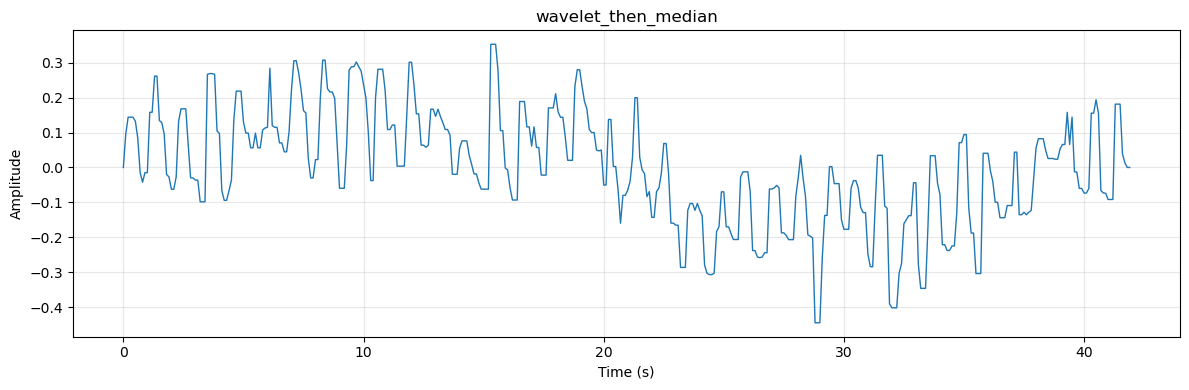

In [778]:
# === 四種基礎處理 ===
from scipy.signal import medfilt

try:
    import pywt
except ImportError:
    pywt = None

def step_bp(x, fs, lo=0.8, hi=3.0):
    return bandpass(x, fs, lo, hi)

def step_median(x, fs, ksize=5):
    k = int(max(3, ksize//2*2+1))      # 奇數
    return medfilt(x, kernel_size=k)

def step_wavelet(x, fs, wavelet='db4', level=3):
    if pywt is None:
        return x
    coeffs = pywt.wavedec(x, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745 + 1e-12
    thr = sigma * np.sqrt(2*np.log(len(x)))
    coeffs = [pywt.threshold(c, value=thr, mode='soft') for c in coeffs]
    y = pywt.waverec(coeffs, wavelet)[:len(x)]
    return y

def step_amp(x, fs, win_sec=1.0):
    n = max(3, int(round(win_sec*fs)))
    k = np.ones(n)/n
    return np.convolve(x, k, mode='same')

# === 可組合：建立 12 組有序雙步管線 A→B ===
from itertools import permutations
import re, numpy as np, pandas as pd

PRIMS = {
    "median":   lambda x, fs: step_median(x, fs, ksize=5),
    "wavelet":  lambda x, fs: step_wavelet(x, fs, wavelet='db4', level=3),
    "amp":      lambda x, fs: step_amp(x, fs, win_sec=1.0),
    "bp":       lambda x, fs: step_bp(x, fs, lo=0.8, hi=3.0),
}

PIPELINES = []
for a, b in permutations(PRIMS.keys(), 2):   # 有序排列，不含同名連續
    name = f"{a}_then_{b}"
    fn = (lambda A=a, B=b: (lambda x, fs: PRIMS[B](PRIMS[A](x, fs), fs)))()
    PIPELINES.append((name, fn))

def _fs_from_t(t):
    dt = np.nanmedian(np.diff(t)) if len(t) > 1 else np.nan
    return float(1.0/dt) if np.isfinite(dt) and dt > 0 else 10.0

def _sanitize_key(name):
    return re.sub(r'[^a-z0-9]+', '_', name.lower()).strip('_')

def build_pairwise_preproc(all_sample_wave):
    """
    將 12 組 A→B 管線套到每個樣本的 mmv，輸出到 it['pre_processing'][key]=DataFrame(t_sec,wave)
    """
    for it in all_sample_wave:
        df_mmv = it["mmv"]                       # 需要欄位: t_sec, wave
        t = pd.to_numeric(df_mmv["t_sec"], errors="coerce").to_numpy(dtype=float)
        x = pd.to_numeric(df_mmv["wave"],  errors="coerce").to_numpy(dtype=float)
        m = np.isfinite(t) & np.isfinite(x)
        t, x = t[m], x[m]
        fs = _fs_from_t(t)

        pre = {}
        for name, fn in PIPELINES:
            y = fn(x, fs)
            if len(y) != len(t):
                y = y[:len(t)]
            key = _sanitize_key(name)
            pre[key] = pd.DataFrame({"t_sec": t, "wave": y})

        it["pre_processing"] = pre
        # 可視需要印出
        # print(it['path'], "pairs:", list(pre.keys()))

# 執行
build_pairwise_preproc(all_sample_wave)

# 取最後一組並畫圖（示例）
last = all_sample_wave[-1]
last_key = sorted(last["pre_processing"].keys())[-1]
df_last = last["pre_processing"][last_key]
plt.figure(figsize=(12,4))
plt.plot(df_last["t_sec"], df_last["wave"], lw=1)
plt.title(f"{last_key}")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

In [779]:
# 查看有哪些預處理方法
all_sample_wave[0]["pre_processing"].keys()
import numpy as np
import pandas as pd

for num in all_sample_wave:
    pre = num.get('pre_processing', {})
    if not pre:
        continue

    num.setdefault('preproc_wave', {})  # 只存處理後的波形
    for mkey, df_pp in pre.items():
        # 僅保留 t_sec、wave，原樣放入
        df_pp2 = pd.DataFrame({
            "t_sec": pd.to_numeric(df_pp["t_sec"], errors="coerce"),
            "wave":  pd.to_numeric(df_pp["wave"],  errors="coerce"),
        }).dropna(subset=["t_sec","wave"]).reset_index(drop=True)

        num['preproc_wave'][mkey] = df_pp2

    #print(num['path'], "methods stored:", list(num['preproc_wave'].keys()))

Plotting from: e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data\sample_181


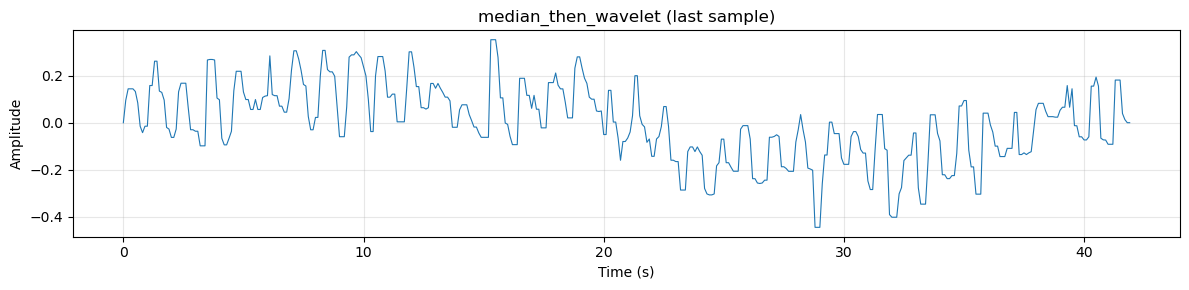

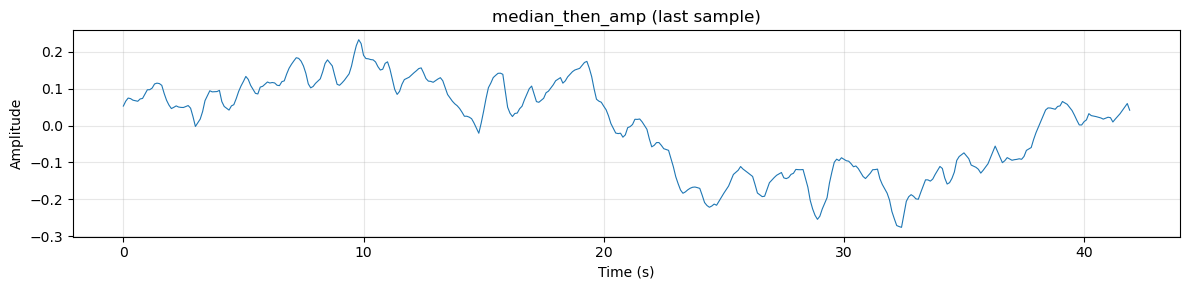

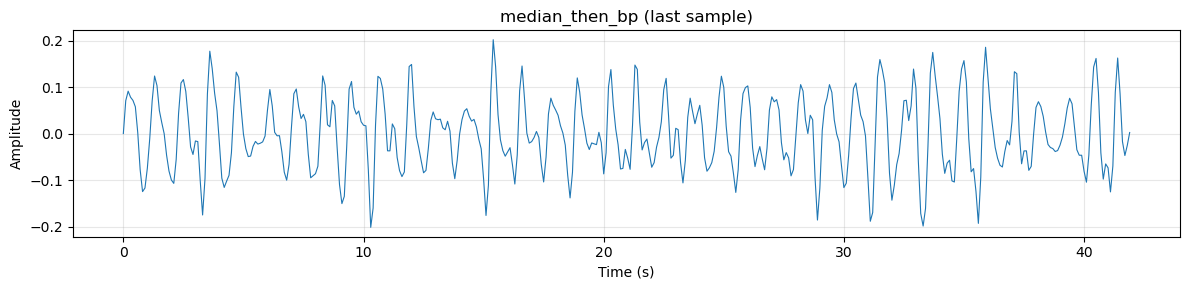

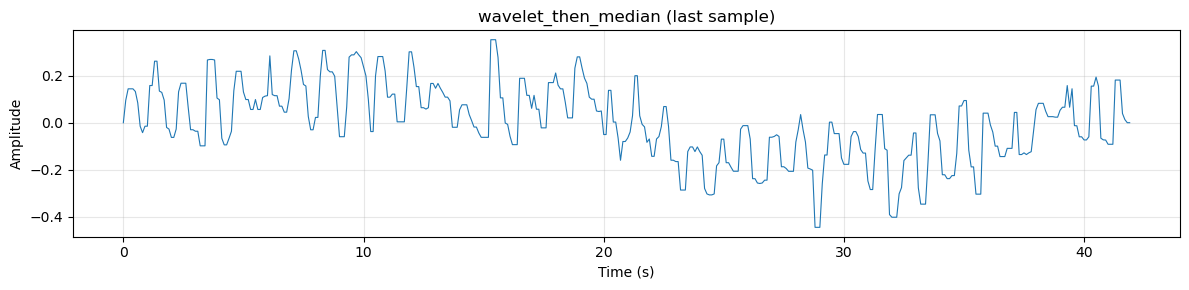

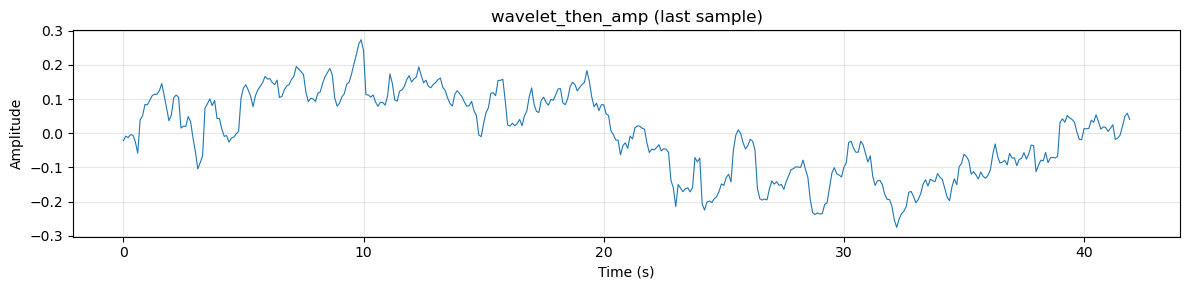

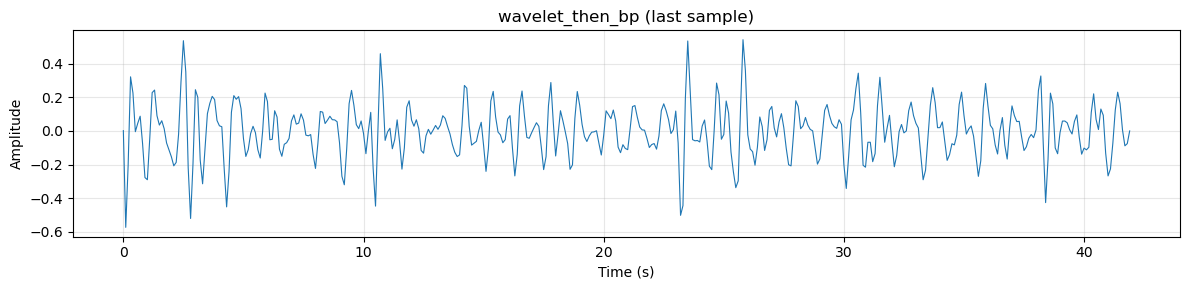

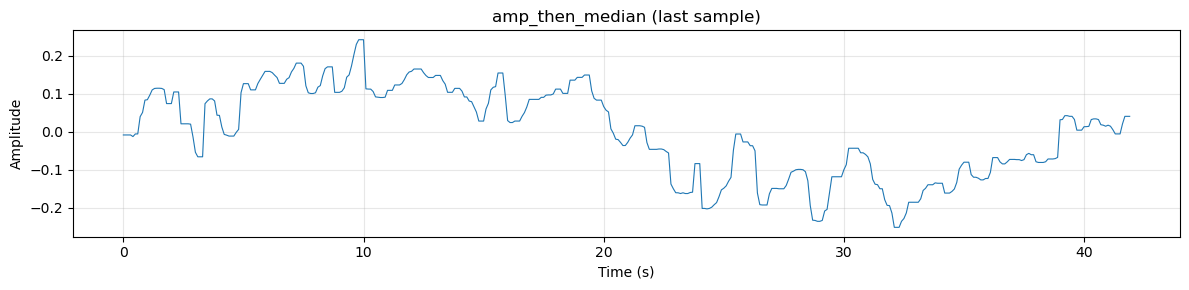

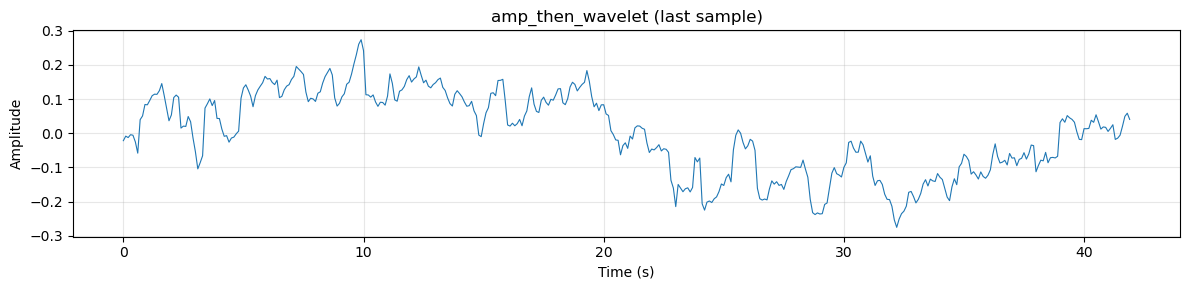

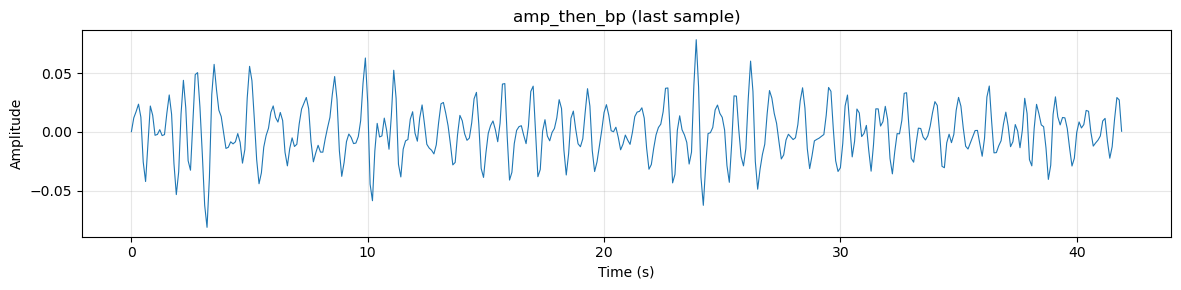

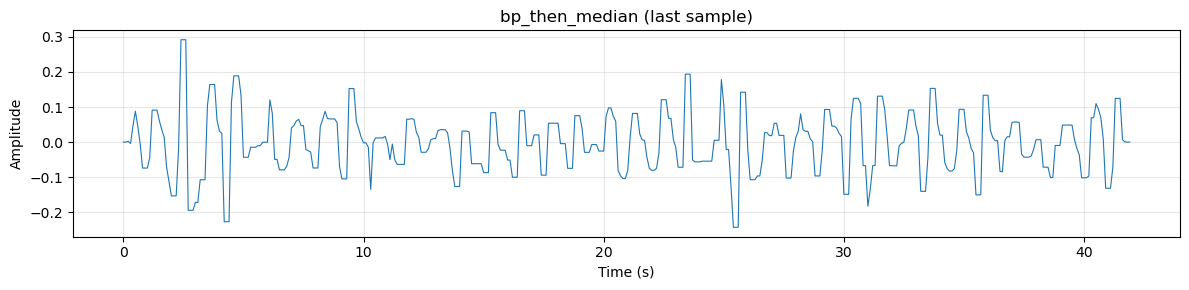

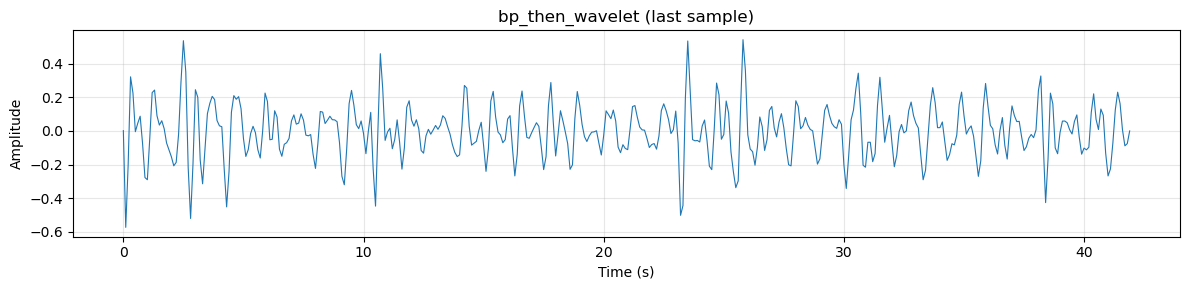

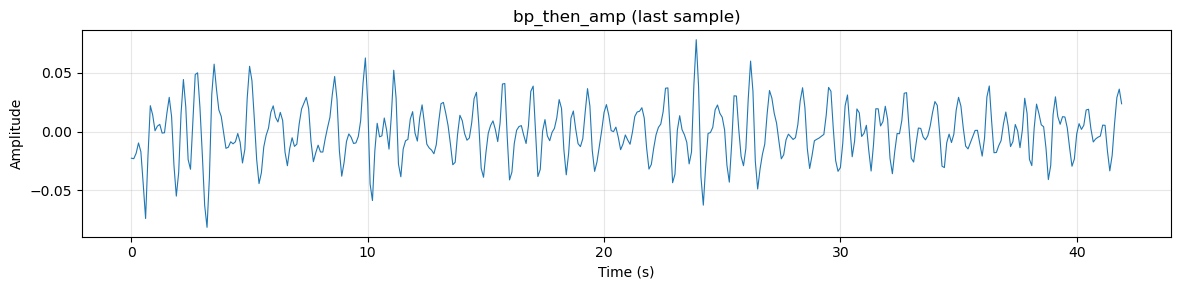

In [780]:
import matplotlib.pyplot as plt

# 找出最後一個 sample
num = all_sample_wave[-1]
preproc = num.get("pre_processing", {})

if not preproc:
    print("no pre_processing found in last sample")
else:
    print("Plotting from:", num["path"])
    for name, df in preproc.items():
        t = df["t_sec"].to_numpy(float)
        y = df["wave"].to_numpy(float)
        plt.figure(figsize=(12, 3))
        plt.plot(t, y, lw=0.8)
        plt.title(f"{name} (last sample)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

In [781]:
import numpy as np, pandas as pd, os

# --- helpers ---
def _infer_fs_from_t(t, fallback=10.0):
    t = np.asarray(t, float)
    if t.size > 1:
        dt = np.nanmedian(np.diff(t))
        if np.isfinite(dt) and dt > 0:
            return float(1.0/dt)
    return float(fallback)

def _hr_fft_peak_bpm(y, fs, lo=0.8, hi=3.0):
    y = np.asarray(y, float)
    n = len(y)
    if n < 16 or fs <= 0:
        return np.nan
    w = np.hanning(n)
    Y = np.fft.rfft((y - np.nanmean(y)) * w)
    f = np.fft.rfftfreq(n, 1.0/fs)
    band = (f >= lo) & (f <= hi)
    if not np.any(band):
        return np.nan
    idx = np.nanargmax(np.abs(Y[band]))
    f_pk = f[band][idx]
    return float(f_pk * 60.0)

# --- build long table: sample × method ---
rows = []
for it in all_sample_wave:
    sample = os.path.basename(str(it.get("path","")))
    gt_hr = float(it.get("ecg_hr_res", np.nan))
    pre = it.get("pre_processing", {}) or {}
    for mkey, dfw in pre.items():
        t = dfw["t_sec"].to_numpy(float)
        x = dfw["wave"].to_numpy(float)
        fs = _infer_fs_from_t(t, fallback=10.0)
        est = _hr_fft_peak_bpm(x, fs, lo=0.8, hi=3.0)
        rows.append({
            "sample": sample,
            "method": mkey,
            "ECG_HR_bpm": gt_hr,
            "Est_HR_bpm": est,
            "Diff_bpm": est - gt_hr if np.isfinite(est) and np.isfinite(gt_hr) else np.nan,
            "AbsErr_bpm": abs(est - gt_hr) if np.isfinite(est) and np.isfinite(gt_hr) else np.nan,
        })

df_long = pd.DataFrame(rows).sort_values(["method","sample"]).reset_index(drop=True)
print(df_long.head())

# --- per-method summary across all samples (累加/平均) ---
method_sum = (
    df_long.groupby("method", as_index=False)
      .agg(
          N=("sample","count"),
          MAE_bpm=("AbsErr_bpm","mean"),
          MdAE_bpm=("AbsErr_bpm","median"),
          RMSE_bpm=("Diff_bpm", lambda s: float(np.sqrt(np.nanmean((s.values)**2)))),
          Bias_bpm=("Diff_bpm","mean"),
          TotalAbsErr_bpm=("AbsErr_bpm","sum")
      )
      .sort_values(["MAE_bpm","RMSE_bpm","TotalAbsErr_bpm"], ascending=[True, True, True])
)
print(method_sum)

# 儲存
df_long.to_csv("hr_eval_rhythmwave_long.csv", index=False)
method_sum.to_csv("hr_eval_rhythmwave_method_summary.csv", index=False)

       sample       method  ECG_HR_bpm  Est_HR_bpm   Diff_bpm  AbsErr_bpm
0    sample_0  amp_then_bp   81.131846   82.758621   1.626775    1.626775
1    sample_1  amp_then_bp   78.625101   65.789474 -12.835627   12.835627
2   sample_10  amp_then_bp  101.460541   86.666667 -14.793875   14.793875
3  sample_100  amp_then_bp   68.778405   75.000000   6.221595    6.221595
4  sample_101  amp_then_bp   62.538904   77.419355  14.880451   14.880451
                 method    N    MAE_bpm   MdAE_bpm   RMSE_bpm   Bias_bpm  \
0           amp_then_bp  182  12.477289  13.558354  16.380767  -0.922538   
3           bp_then_amp  182  12.477289  13.558354  16.380767  -0.922538   
5       bp_then_wavelet  182  12.546222  13.561633  16.990077  -0.477234   
10      wavelet_then_bp  182  12.546222  13.561633  16.990077  -0.477234   
2      amp_then_wavelet  182  13.170732  13.593632  17.902895  -2.170021   
9      wavelet_then_amp  182  13.170732  13.593632  17.902895  -2.170021   
1       amp_then_median 

## reconstructed


In [782]:
all_sample_wave[0].keys() # 查看有哪些欄位


dict_keys(['path', 'ecg', 'mmv', 'summary', 'ecg_hr_res', 'pre_processing', 'preproc_wave'])

### analuze cepstrum test 

訊號 → FFT → 取對數 → IFFT → 倒頻譜

In [783]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def analyze_cepstrum(summary,
                     save_plots=False,
                     show_plots=False,
                     outdir=None,
                     hr_range_bpm=(40, 200),
                     lifter_q_sec=0.10,
                     win_sec=10.0,
                     hop_sec=0.5,
                     eps=1e-12):
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    x = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])
    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')

    N = len(x)
    hr_lo, hr_hi = hr_range_bpm
    q_lo = 60.0 / hr_hi
    q_hi = 60.0 / hr_lo

    # ---------- 全段倒頻譜（使用 N 長度窗，nfft 取 >= N 的 2 次方） ----------
    nfft_global = int(2 ** np.ceil(np.log2(max(16, N))))
    w_glob = signal.windows.hann(N, sym=False)
    Xg = np.fft.rfft(x * w_glob, n=nfft_global)
    Lg = np.log(np.maximum(np.abs(Xg), eps))
    c_global = np.real(np.fft.irfft(Lg, n=nfft_global))
    q_axis_g = np.arange(nfft_global) / fs

    # liftering 與 HR 搜尋窗
    c_glift = c_global.copy()
    c_glift[q_axis_g < lifter_q_sec] = 0.0
    mask_hr_q_g = (q_axis_g >= max(q_lo, lifter_q_sec)) & (q_axis_g <= q_hi)
    q_star_global = q_axis_g[mask_hr_q_g][np.argmax(c_glift[mask_hr_q_g])]
    hr_global = 60.0 / q_star_global

    # ---------- 滑動窗參數（不超過訊號長度） ----------
    win_len = int(round(win_sec * fs))
    hop_len = int(round(hop_sec * fs))
    if win_len > N:
        win_len = N
    if hop_len < 1:
        hop_len = 1
    if win_len < 4:
        raise ValueError("win_sec too short given fs and signal length.")

    nfft_win = int(2 ** np.ceil(np.log2(max(16, win_len))))
    q_axis_w = np.arange(nfft_win) / fs
    mask_hr_q_w = (q_axis_w >= max(q_lo, lifter_q_sec)) & (q_axis_w <= q_hi)

    # ---------- 逐窗 cepstrogram 與 HR 軌跡 ----------
    w = signal.windows.hann(win_len, sym=False)
    centers, q_peaks, hr_track, conf_psr, frames = [], [], [], [], []

    for start in range(0, max(1, N - win_len + 1), hop_len):
        seg = x[start:start + win_len]
        if len(seg) < win_len:
            break
        Xw = np.fft.rfft(seg * w, n=nfft_win)
        Lw = np.log(np.maximum(np.abs(Xw), eps))
        c = np.real(np.fft.irfft(Lw, n=nfft_win))

        # liftering
        c[q_axis_w < lifter_q_sec] = 0.0

        # HR 對應 quefrency 主峰
        c_hr = np.where(mask_hr_q_w, c, 0.0)
        pk_idx = int(np.argmax(c_hr))
        q_pk = q_axis_w[pk_idx]
        hr = 60.0 / q_pk

        # PSR（主峰對旁瓣比）
        sl_mask = mask_hr_q_w.copy()
        win_ex = 2
        sl_mask[max(0, pk_idx - win_ex):min(len(sl_mask), pk_idx + win_ex + 1)] = False
        sidelobe = np.mean(c[sl_mask]) if np.any(sl_mask) else 0.0
        psr = (c[pk_idx] / (sidelobe + 1e-9)) if sidelobe > 0 else np.inf

        centers.append(t_sec[min(start + win_len // 2, N - 1)])
        q_peaks.append(q_pk)
        hr_track.append(hr)
        conf_psr.append(psr)
        frames.append(c)

    centers = np.asarray(centers)
    q_peaks = np.asarray(q_peaks)
    hr_track = np.asarray(hr_track)
    conf_psr = np.asarray(conf_psr)
    cepstrogram = np.stack(frames, axis=1) if len(frames) else np.zeros((nfft_win, 0))

    # ---------- 視覺化 ----------
    if show_plots or save_plots:
        print("=" * 60)
        print("Cepstrum Analysis")
        print("=" * 60)
        print(f"Global HR estimate from cepstrum: {hr_global:.1f} bpm")
        if len(hr_track):
            print(f"Track HR: mean={np.nanmean(hr_track):.1f} bpm, std={np.nanstd(hr_track):.1f} bpm")
        print(f"Quefrency search window: [{q_lo:.3f}, {q_hi:.3f}] s  (HR {hr_lo}-{hr_hi} bpm)")
        print(f"Liftering: q < {lifter_q_sec:.3f} s set to 0")

        # 全段
        plt.figure(figsize=(10, 4))
        plt.plot(q_axis_g, c_global, label="Cepstrum (global)")
        plt.axvspan(0, lifter_q_sec, alpha=0.15, label="liftered")
        plt.axvline(q_star_global, linestyle='--', label=f'Peak={q_star_global:.3f}s ({hr_global:.1f} bpm)')
        plt.xlim(0, min(2.0, q_hi * 1.2))
        plt.xlabel("Quefrency (s)"); plt.ylabel("Amplitude"); plt.title("Global Real Cepstrum")
        plt.legend(); plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrum_global.png", dpi=200)
        plt.show()

        # cepstrogram
        if cepstrogram.shape[1] > 0:
            q_max_plot = min(2.0, q_hi * 1.2)
            q_mask_plot = q_axis_w <= q_max_plot
            C_db = 10 * np.log10(np.maximum(cepstrogram[q_mask_plot, :], eps))
            plt.figure(figsize=(12, 5))
            im = plt.pcolormesh(centers, q_axis_w[q_mask_plot], C_db, shading='gouraud')
            plt.colorbar(im, label='Cepstrum Power (dB)')
            plt.xlabel("Time (s)"); plt.ylabel("Quefrency (s)"); plt.title("Cepstrogram")
            plt.tight_layout()
            if save_plots: plt.savefig(f"{outdir}/cepstrogram.png", dpi=200)
            plt.show()

            plt.figure(figsize=(12, 4))
            plt.plot(centers, hr_track, linewidth=1.5, label="HR from cepstrum")
            if summary.get('est_hr_bpm') and np.isfinite(summary['est_hr_bpm']):
                plt.axhline(summary['est_hr_bpm'], linestyle='--',
                            label=f"Est. HR (summary) {summary['est_hr_bpm']:.1f} bpm")
            plt.xlabel("Time (s)"); plt.ylabel("HR (bpm)"); plt.title("HR Track from Cepstrum Peaks")
            plt.legend(); plt.tight_layout()
            if save_plots: plt.savefig(f"{outdir}/hr_track_cepstrum.png", dpi=200)
            plt.show()

            plt.figure(figsize=(12, 3))
            plt.plot(centers, conf_psr, linewidth=1.2)
            plt.xlabel("Time (s)"); plt.ylabel("PSR"); plt.title("Peak-to-Sidelobe Ratio")
            plt.tight_layout()
            if save_plots: plt.savefig(f"{outdir}/cepstrum_confidence_psr.png", dpi=200)
            plt.show()
    
    if hr_track.size > 0:
        mask = np.isfinite(hr_track) & np.isfinite(conf_psr)
        if mask.any():
            hr_track_est = float(np.average(hr_track[mask], weights=conf_psr[mask]))
        else:
            hr_track_est = float(np.nan)
    else:
        hr_track_est = float("nan")
    if not np.isfinite(hr_track_est):
        hr_track_est = float(hr_global)

    return {
        "hr_track_est_bpm": hr_track_est,
        "q_axis_global_sec": q_axis_g,
        "cepstrum_global": c_global,
        "q_star_global_sec": float(q_star_global),
        "hr_global_bpm": float(hr_global),
        "q_axis_win_sec": q_axis_w,
        "centers_sec": centers,
        "cepstrogram": cepstrogram,
        "q_peak_track_sec": q_peaks,
        "hr_track_bpm": hr_track,
        "confidence_psr": conf_psr,
        "params": {
            "fs_Hz": fs, "win_sec": win_sec, "hop_sec": hop_sec,
            "hr_range_bpm": hr_range_bpm, "lifter_q_sec": lifter_q_sec,
            "nfft_global": nfft_global, "nfft_win": nfft_win
        }
    }


C:\Users\op237\AppData\Local\Temp\ipykernel_14256\182401758.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  hr = 60.0 / q_pk


Total samples: 182


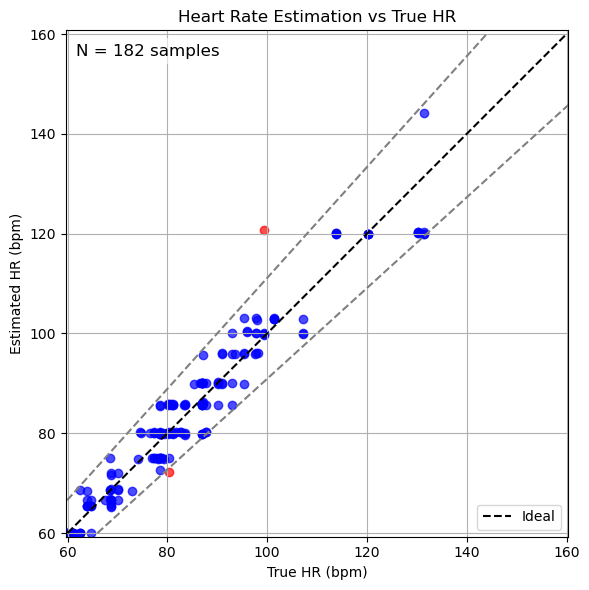

Samples with APE > 10%:
sample_132: +21.38 bpm (APE = 21.52%)
sample_146: -8.20 bpm (APE = 10.20%)
sample_172: -51.96 bpm (APE = 48.44%)
Total: 3 samples
Sample IDs: [132, 146, 172]


In [784]:
import matplotlib.pyplot as plt
import numpy as np
import os

diff_over_5 = []  # 保留結構用
hr_true_list, hr_est_list = [], []
ape_list = []     # 每筆樣本的 APE(%)

base_dir = r"e:\重要文件\毫米波\radar-heartbeat-detection\experiment\data"
ape_threshold = 10.0  # 期刊常用門檻

# ----------------------------
# 主迴圈
# ----------------------------
for num in all_sample_wave:
    num_summary = num.get('summary', {})
    cep_results = analyze_cepstrum(num_summary, save_plots=False, show_plots=False)

    hr_est = cep_results["hr_global_bpm"]
    hr_true = num.get("ecg_hr_res", np.nan)

    hr_true_list.append(hr_true)
    hr_est_list.append(hr_est)

    # 計算 APE
    if np.isfinite(hr_true) and hr_true > 0:
        ape = abs(hr_est - hr_true) / hr_true * 100.0
    else:
        ape = np.nan
    ape_list.append(ape)

    if np.isfinite(ape) and ape > ape_threshold:
        diff_over_5.append(
            int(os.path.relpath(num.get("path", "unknown"), base_dir).replace('sample_', ''))
        )

# ----------------------------
# 顯示資料筆數
# ----------------------------
num_samples = len(all_sample_wave)
print(f"Total samples: {num_samples}")

# ----------------------------
# 畫散佈圖
# ----------------------------
plt.figure(figsize=(6, 6))

# 顏色分類
for i in range(num_samples):
    if np.isfinite(ape_list[i]) and ape_list[i] > ape_threshold:
        color = 'red'
        label = f'APE > {ape_threshold:.0f}%' if 'label_red' not in globals() else ""
        globals()['label_red'] = True
    else:
        color = 'blue'
        label = 'APE ≤ 10%' if 'label_blue' not in globals() else ""
        globals()['label_blue'] = True

    plt.scatter(hr_true_list[i], hr_est_list[i], color=color, alpha=0.7, label=label)

# 畫 y=x 與 ±10% 區間
x_line = np.linspace(60, 160, 100)
plt.plot(x_line, x_line, 'k--', label='Ideal')
plt.plot(x_line * 1.10, x_line, 'gray', linestyle='--')
plt.plot(x_line * 0.90, x_line, 'gray', linestyle='--')

plt.xlabel("True HR (bpm)")
plt.ylabel("Estimated HR (bpm)")
plt.title("Heart Rate Estimation vs True HR")

# ----------------------------
# 在圖上顯示 total number of samples
# ----------------------------
plt.text(0.02, 0.95, f"N = {num_samples} samples",
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# ----------------------------
# Legend（顯示 color example）
# ----------------------------
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.xlim(60, 160)
plt.ylim(60, 160)
plt.tight_layout()
plt.show()

# ----------------------------
# 列出 APE 超標樣本
# ----------------------------
exceed_list = []
for i, num in enumerate(all_sample_wave):
    diff = hr_est_list[i] - hr_true_list[i]
    ape = ape_list[i]

    if np.isfinite(ape) and ape > ape_threshold:
        sample_id = int(os.path.relpath(num.get("path", "unknown"), base_dir).replace('sample_', ''))
        exceed_list.append((sample_id, diff, ape))

print(f"Samples with APE > {ape_threshold:.0f}%:")
for sid, diff, ape in exceed_list:
    print(f"sample_{sid:02d}: {diff:+.2f} bpm (APE = {ape:.2f}%)")

print(f"Total: {len(exceed_list)} samples")
print("Sample IDs:", [sid for sid, _, _ in exceed_list])


In [785]:
rows = []
for lifter in [ 0.2, 0.5, 0.7]:
    for win in [4.0, 8.0, 12.0]:
        for hop in [ 0.2, 0.5, 1.0]:
            ests, gts = [], []
            for num in all_sample_wave:
                s = num['summary']
                cep = analyze_cepstrum(s, save_plots=False, show_plots=False,
                                       lifter_q_sec=lifter,
                                       win_sec=win, hop_sec=hop)
                est = cep["hr_track_est_bpm"]  # ← 改用軌跡估計
                gt  = num.get("ecg_hr_res", np.nan)
                ests.append(est); gts.append(gt)
            ests, gts = np.array(ests, float), np.array(gts, float)
            mae  = np.nanmean(np.abs(ests - gts))
            rmse = np.sqrt(np.nanmean((ests - gts)**2))
            rows.append(dict(lifter_q_sec=lifter, win_sec=win, hop_sec=hop,
                             MAE_bpm=mae, RMSE_bpm=rmse))
pd.DataFrame(rows).sort_values(["MAE_bpm","RMSE_bpm"])



C:\Users\op237\AppData\Local\Temp\ipykernel_14256\182401758.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  hr = 60.0 / q_pk


,lifter_q_sec,win_sec,hop_sec,MAE_bpm,RMSE_bpm
10,0.5,4.0,0.5,8.609201,16.275011
9,0.5,4.0,0.2,9.057765,16.375988
11,0.5,4.0,1.0,9.299702,16.899336
0,0.2,4.0,0.2,9.774263,15.242028
1,0.2,4.0,0.5,10.233135,16.638067
4,0.2,8.0,0.5,10.341000,17.404438
5,0.2,8.0,1.0,10.524268,17.608247
2,0.2,4.0,1.0,10.912700,17.446129
3,0.2,8.0,0.2,11.276774,18.897586
17,0.5,12.0,1.0,11.360545,20.023272


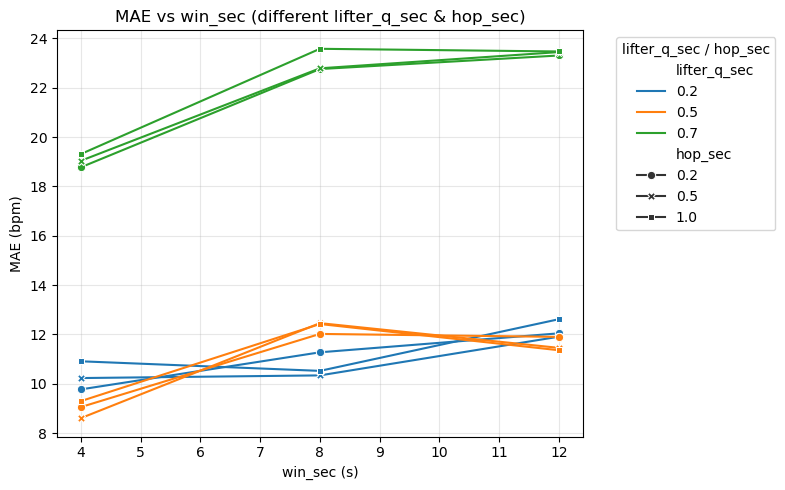

In [786]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(rows)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=df,
    x="win_sec",
    y="MAE_bpm",
    hue="lifter_q_sec",
    style="hop_sec",
    markers=True,
    dashes=False,
    palette="tab10"
)
plt.title("MAE vs win_sec (different lifter_q_sec & hop_sec)")
plt.xlabel("win_sec (s)")
plt.ylabel("MAE (bpm)")
plt.grid(alpha=0.3)
plt.legend(title="lifter_q_sec / hop_sec", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [787]:
# best 0.5 4.0 0.5

In [788]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 產生各類噪聲 ----
def _white_noise(n, rng):
    return rng.standard_normal(n)

def _pink_noise(n, rng):
    # 簡易 1/f：白噪通過1階IIR積分近似
    x = rng.standard_normal(n)
    y = np.zeros_like(x)
    a = 0.985  # 越接近1越偏低頻
    for i in range(1, n):
        y[i] = a*y[i-1] + (1-a)*x[i]
    y /= np.std(y) + 1e-12
    return y

def _sin_component(n, fs, f_hz, rng, amp=1.0):
    t = np.arange(n)/fs
    phi = rng.uniform(0, 2*np.pi)
    return amp*np.sin(2*np.pi*f_hz*t + phi)

def _baseline_wander(n, fs, rng):
    # 0.1–0.4 Hz 正弦和
    freqs = rng.uniform(0.1, 0.4, size=3)
    y = sum(_sin_component(n, fs, f, rng, 1.0) for f in freqs)
    y /= np.std(y) + 1e-12
    return y

def _resp_interf(n, fs, rng):
    # 0.2–0.4 Hz 強單頻
    f = rng.uniform(0.2, 0.4)
    y = _sin_component(n, fs, f, rng, 1.0)
    y /= np.std(y) + 1e-12
    return y

def _band_noise(n, fs, rng, lo=0.8, hi=3.0, order=4):
    # 帶通白噪到心跳帶
    from scipy.signal import butter, filtfilt
    x = rng.standard_normal(n)
    ny = 0.5*fs
    b, a = butter(order, [lo/ny, hi/ny], btype='band')
    y = filtfilt(b, a, x)
    y /= np.std(y) + 1e-12
    return y

def _spikes(n, rng, rate=0.01, amp=5.0, width=3):
    y = np.zeros(n)
    k = rng.binomial(1, rate, size=n).astype(bool)
    idx = np.flatnonzero(k)
    for i in idx:
        j1, j2 = i, min(n, i+width)
        y[j1:j2] += amp * (1.0 - np.linspace(0,1,j2-j1))
    y /= np.std(y) + 1e-12 if np.std(y) > 0 else 1.0
    return y

def make_noise(kind, n, fs, rng):
    if kind == "white":   return _white_noise(n, rng)
    if kind == "pink":    return _pink_noise(n, rng)
    if kind == "baseline":return _baseline_wander(n, fs, rng)
    if kind == "resp":    return _resp_interf(n, fs, rng)
    if kind == "band":    return _band_noise(n, fs, rng)
    if kind == "spike":   return _spikes(n, rng)
    raise ValueError(f"unknown noise kind: {kind}")

# ---- 依 SNR 疊加噪聲 ----
def add_noise_to_summary(summary, snr_db, kind="white", seed=0):
    df = summary["dataframe"]
    fs = float(summary["fs_Hz"])
    t  = df["t_sec"].to_numpy(float)
    x  = df["heartbeat"].to_numpy(float)
    n  = len(x)
    rng = np.random.default_rng(seed)
    noise = make_noise(kind, n, fs, rng)
    Px = np.mean((x - np.mean(x))**2)
    Pn = np.mean(noise**2)
    if np.isinf(snr_db):   # ∞ dB → 不加噪
        y = x.copy()
    else:
        k = np.sqrt(Px / (Pn * 10.0**(snr_db/10.0) + 1e-12))
        y = x + k*noise
    # 回傳同樣 summary 結構
    df_out = pd.DataFrame({"t_sec": t, "heartbeat": y})
    return {
        "samples": int(n),
        "duration_s": float(t[-1]-t[0]) if n>1 else 0.0,
        "fs_Hz": fs,
        "est_hr_bpm": None,
        "csv": "",
        "dataframe": df_out
    }

# ---- 基準評估（使用 hr_track_est_bpm，退回 global）----
def estimate_hr(summary, **cep_kwargs):
    out = analyze_cepstrum(summary, save_plots=False, show_plots=False, **cep_kwargs)
    est = out.get("hr_track_est_bpm", np.nan)
    if not np.isfinite(est):
        est = out["hr_global_bpm"]
    return float(est)

# ---- 主實驗：不同噪聲 × SNR 網格 ----
def noise_benchmark(all_sample_wave,
                    noise_kinds=("white","pink","baseline","resp","band","spike"),
                    snr_list_db=(np.inf,20,10,5,0,-5),
                    lifter_q_sec=0.10, win_sec=10.0, hop_sec=0.5,
                    hr_range_bpm=(50,160),
                    seed=0):
    rows = []
    for kind in noise_kinds:
        for snr in snr_list_db:
            ests, gts = [], []
            for it in all_sample_wave:
                s_clean = it["summary"]                        # 乾淨 summary
                s_noisy = add_noise_to_summary(s_clean, snr, kind=kind, seed=seed)
                est = estimate_hr(s_noisy,
                                  lifter_q_sec=lifter_q_sec,
                                  win_sec=win_sec, hop_sec=hop_sec,
                                  hr_range_bpm=hr_range_bpm)
                gt  = float(it.get("ecg_hr_res", np.nan))
                ests.append(est); gts.append(gt)
            ests = np.array(ests, float); gts = np.array(gts, float)
            mae  = np.nanmean(np.abs(ests - gts))
            rmse = np.sqrt(np.nanmean((ests - gts)**2))
            bias = np.nanmean(ests - gts)
            rows.append(dict(noise=kind, SNR_dB=snr, MAE_bpm=mae, RMSE_bpm=rmse, Bias_bpm=bias))
    return pd.DataFrame(rows)

# ---- 跑實驗 ----
df_noise = noise_benchmark(
    all_sample_wave,
    noise_kinds=("white","pink","baseline","resp","band","spike"),
    snr_list_db=(np.inf, 20, 10, 5, 0, -5),
    lifter_q_sec=0.10, win_sec=8.0, hop_sec=0.2,
    hr_range_bpm=(50,160),
    seed=42
)

print(df_noise.sort_values(["RMSE_bpm","MAE_bpm"]).head())

# ---- 視覺化：一張圖（MAE），X=SNR，線=噪聲型別 ----
plt.figure(figsize=(8,5))
for kind, g in df_noise.groupby("noise"):
    g = g.sort_values("SNR_dB")
    plt.plot(g["SNR_dB"].values, g["MAE_bpm"].values, marker='o', label=kind)
plt.xlabel("SNR (dB)")
plt.ylabel("MAE (bpm)")
plt.title("HR estimation MAE vs SNR under different noise types")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 若也要 RMSE，在同圖改 y 值或另畫一張


C:\Users\op237\AppData\Local\Temp\ipykernel_14256\182401758.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  hr = 60.0 / q_pk


KeyboardInterrupt: 